In [1]:
import sys
import os

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow( im ):
    cv2.imshow('',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

things = MetadataCatalog.get("coco_2017_train").thing_classes
print(things)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [2]:
##### CAMERA CALIBRATION CONFIG - this configuration comes from how we set up Cameras in CARLA

# Camera baseline distances
baseline_F = 0.8 # 80cm on top car
baseline_LC = np.sqrt([0.2*0.2 *2])[0] # left corner
baseline_RC = np.sqrt([0.2*0.2 *2])[0] # right corner
baseline_L = 0.5 # left side
baseline_R = 0.5 # right side

# camera properties
fov=90
W=1280
H=720

fov = fov / 360. * 2. * np.pi
f = W / (2. * np.tan(fov / 2.))  # focus length

In [3]:
from scipy.spatial.transform import Rotation as R

def to4x4Tensor(matrix):
    matrix = matrix.tolist()
    matrix[0].append(0.0)
    matrix[1].append(0.0)
    matrix[2].append(0.0)
    matrix.append([0.0,0.0,0.0,1.0])
    return torch.tensor(matrix)

# Transformation matrices - first swap then rotate then translate : F * R * Swap

# {"x": z, "y": x, "z": y } Switch between CARLA UE and image coordinate system
swap_axes = torch.tensor([[0,0,1.0,0],[1,0,0,0],[0,1.0,0,0],[0,0,0,1.]])

# yaw, pitch, roll
# Front stereo
translate_F = torch.tensor([[1.,0,0,-0.3],[0,1.,0,0.4],[0,0,1.,-1.0],[0,0,0,1.]])
transform_F = torch.mm(translate_F, swap_axes)

# Right Corner stereo
translate_RC = torch.tensor([[1.,0,0,-0.2],[0,1.,0,-0.4],[0,0,1.,-1.0],[0,0,0,1.]])
rotate_RC = R.from_euler('zyx', [45.0, 0.0, 0.0], degrees=True).as_matrix()
rotate_RC = to4x4Tensor(rotate_RC)
transform_RC = torch.mm(rotate_RC, swap_axes)
transform_RC = torch.mm(translate_RC, transform_RC)

# Left Corner stereo
translate_LC = torch.tensor([[1.,0,0,0],[0,1.,0,0.6],[0,0,1.,-1.0],[0,0,0,1.]])
rotate_LC = R.from_euler('zyx', [-45.0, 0.0, 0.0], degrees=True).as_matrix()
rotate_LC = to4x4Tensor(rotate_LC)
transform_LC = torch.mm(rotate_LC, swap_axes)
transform_LC = torch.mm(translate_LC, transform_LC)

# Right stereo
translate_R = torch.tensor([[1.,0,0,0],[0,1.,0,-0.6],[0,0,1.,-1.0],[0,0,0,1.]])
rotate_R = R.from_euler('zyx', [90.0, 0.0, 0.0], degrees=True).as_matrix()
rotate_R = to4x4Tensor(rotate_R)
transform_R = torch.mm(rotate_R, swap_axes)
transform_R = torch.mm(translate_R, transform_R)

# Left stereo
translate_L = torch.tensor([[1.,0,0,0.5],[0,1.,0,0.6],[0,0,1.,-1.0],[0,0,0,1.]])
rotate_L = R.from_euler('zyx', [-90.0, 0.0, 0.0], degrees=True).as_matrix()
rotate_L = to4x4Tensor(rotate_L)
transform_L = torch.mm(rotate_L, swap_axes)
transform_L = torch.mm(translate_L, transform_L)

In [8]:
########### CONFIGURE DETECTRON
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [9]:
########### CONFIGURE STEREO MATCHER
num_disp = 128
window_size = 11
stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size )
stereo.setUniquenessRatio(5)

In [10]:
########### CONFIGURE PATH AND JSON LOGGER
from actorlogger import ActorLogger, Frame
path = "/home/najib/Thesis/Rendering/" + str(4)
subpath = path + "/out/"
saveimpath = path + "/det/"
os.makedirs(saveimpath, exist_ok=True)
actorLogger = ActorLogger(path)

In [11]:
# Depth image saver
dpi = 72
figsize = W / float(dpi), H / float(dpi)
def saveDepth(disparity, path):
    fig = plt.figure(figsize=figsize,frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(disparity, aspect='auto')
    plt.savefig(path, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()

In [12]:
import re
from PIL import Image
import time

In [26]:
def process(frame, frame_id, imgL, imgR, transform_M, baseline, save=False, label=None):
    if(imgL is None or imgR is None):
        return;
    # Calculate disparity with stereo block matching algorithm
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    
    if(save):
        saveDepth(disparity, ('%s/%d%s%s.jpg' % (saveimpath, frame_id, label, "DP")))

    # Predict detections with detectron2
    outputs = predictor(imgL)
    
    if(save):
        v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        detim = v.get_image()
        Image.fromarray(detim, 'RGB').save(('%s/%d%s%s.jpg' % (saveimpath, frame_id, label, "DET")), 'JPEG', quality=85)
    
    # Detect actors
    for i in range(0, len(outputs["instances"])):
        
        if(outputs["instances"].pred_classes[i] not in (0,1,2,3,4,5,6,7)): # Detect only these classes
            continue

        # Mask actor depth
        mask = outputs["instances"].pred_masks[i]
        masked = torch.tensor(disparity)[mask]
        nonnegative = masked > 0  # negative values in depth map mean unmatched regions
        disparities = masked[nonnegative]

        if(disparities.nelement() != 0):
            mean_disparity = disparities.mode().values # Mean of depth
            if torch.isnan(mean_disparity):
                mean_disparity = torch.tensor(0.1)
        else:
            mean_disparity = torch.tensor(0.1)
           
        # Inverse (intrinsic) projection
        [[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
        dx = cx - W/2
        dy = cy - H/2
        z = f*baseline/mean_disparity
        x = dx*z/f
        y = dy*z/f
        
        # Inverse (extrinsic) transform
        impos = torch.tensor([x,y,z,1])
        [x,y,z, _] = torch.mv(transform_M,impos)
        
        x = float(x)
        y = float(y)
        z = float(z)
        frame.addActor("", things[outputs["instances"].pred_classes[i]], 0, {"x": x, "y": y, "z": z })

In [42]:
sortedPaths = os.listdir(subpath)
sortedPaths.sort(key=lambda f: int(re.sub('\D', '', f)))
frame_id = int(re.search(r'\d+', sortedPaths[0]).group())
print("First frame: ", frame_id, " last frame: ", re.search(r'\d+', sortedPaths[-1]).group())

start_time = time.time()
fpsl = []

# Algorithm
while(os.path.exists((subpath + str(frame_id) + 'FL.jpg'))):
    # New frame
    frame = Frame(frame_id)
    print("Processing frame ", frame_id)
    lasts = fpsl[-15:]
    if lasts:
        print("FPS avg: ", np.mean(lasts))

    # Front stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'FL.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'FR.jpg')
    # Hide ego car from front images
    if(imgL is not None and imgR is not None):
        imgL[620:H, 360:W] = [0,0,0]
        imgR[620:H, 0:900] = [15,15,15]
        process(frame, frame_id, imgL, imgR, transform_F, baseline_F, True, "F")

    # Left corner stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'LC2.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'LC1.jpg')
    if(imgL is not None and imgR is not None):
        imgL[640:H, 950:W] = [0,0,0]
        imgR[640:H, 900:W] = [15,15,15]
        process(frame, frame_id, imgL, imgR, transform_LC, baseline_LC, True, "LC")
    
    # Right corner stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'RC1.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'RC2.jpg')
    if(imgL is not None and imgR is not None):
        imgL[640:H, 0:400] = [0,0,0]
        imgR[640:H, 0:320] = [15,15,15]
        process(frame, frame_id, imgL, imgR, transform_RC, baseline_RC, True, "RC")
    
    # Left stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'L2.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'L1.jpg')
    process(frame, frame_id, imgL, imgR, transform_L, baseline_L, True, "L")
    
    # Riht stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'R1.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'R2.jpg')
    process(frame, frame_id, imgL, imgR, transform_R, baseline_R, True, "R")
    
    actorLogger.addFrame(frame)
    frame_id += 1
    
    fpsl.append(1.0 / (time.time() - start_time))
    start_time = time.time()  

actorLogger.save()


First frame:  110  last frame:  262
Processing frame  110
Processing frame  111
FPS avg:  0.4131304905239029


KeyboardInterrupt: 

[[ 2.22044605e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.22044605e-16 -1.00000000e+00 -0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
[[ 2.22044605e-16  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  2.22044605e-16 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  1.00000000e+00]]
tensor([[ 0.7071,  0.0000,  0.7071, -0.3000],
        [ 0.7071,  0.0000, -0.7071,  0.4000],
        [ 0.0000,  1.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


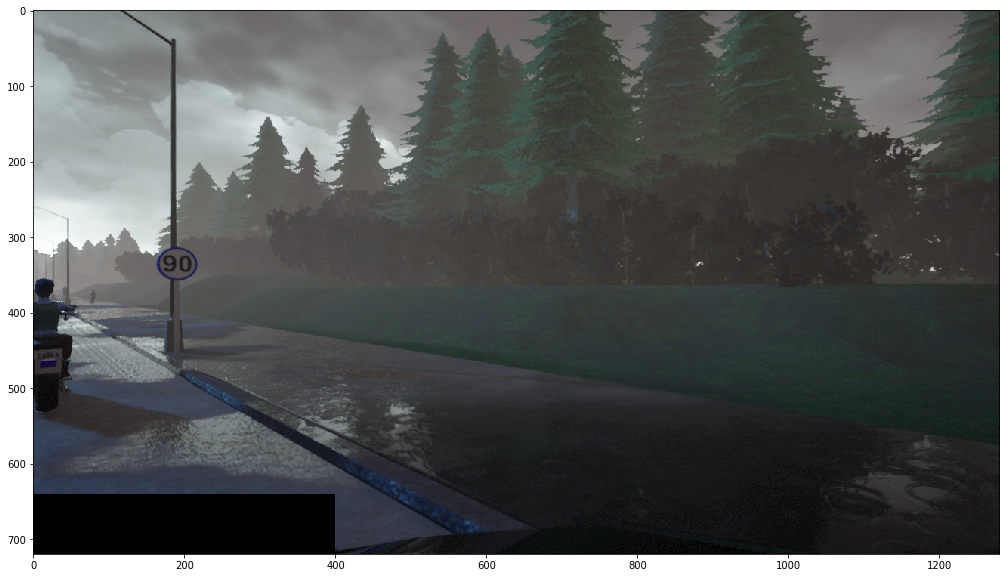

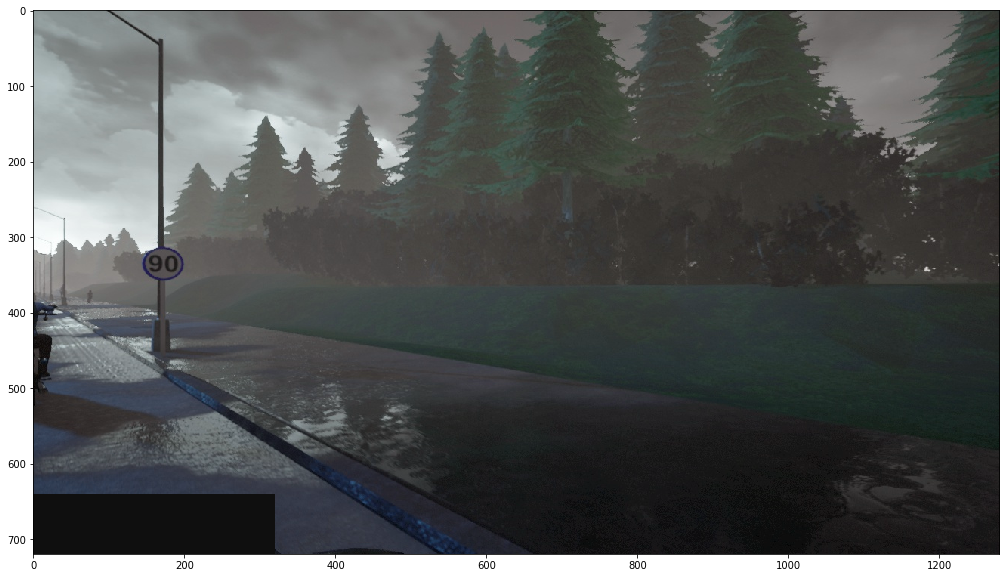

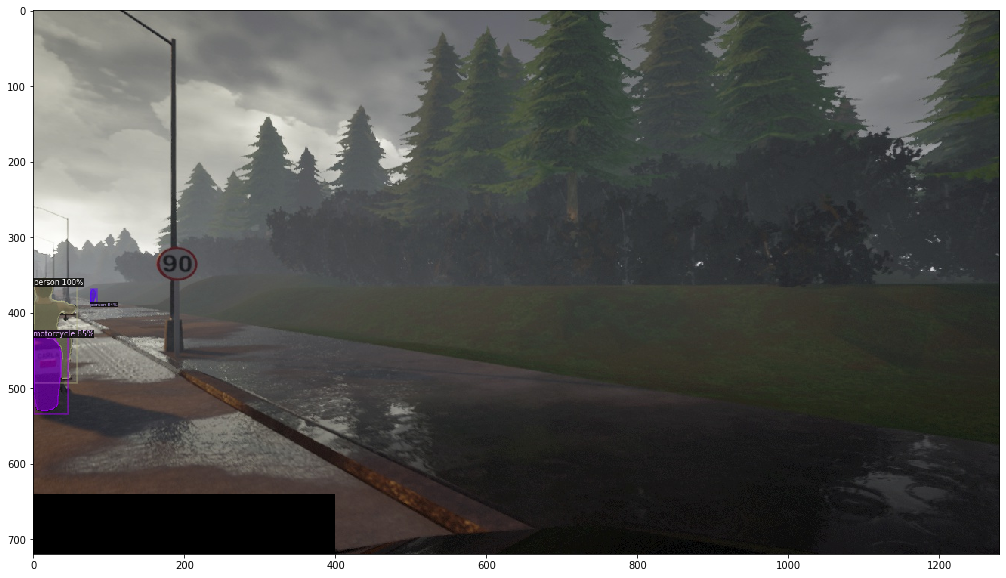

In [21]:
imgL = cv2.imread('447RC1.jpg')
imgR = cv2.imread('447RC2.jpg')

imgL[640:H, 0:400] = [0,0,0]
imgR[640:H, 0:320] = [15,15,15]

plt.figure(figsize=(20,10))
plt.imshow(imgL)
plt.figure(figsize=(20,10))
plt.imshow(imgR)

outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]

# i =3
# [[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
# print(cx, cy)

# grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
# grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
# disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
# disparity = (disp)

# # Depth image saver
# dpi = 72
# figsize = W / float(dpi), H / float(dpi)

# def saveDepth(disparity):
#     fig = plt.figure(figsize=figsize,frameon=False)
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     ax.imshow(disparity, aspect='auto')
#     plt.savefig('/home/najib/Thesis/Thesis/test.jpg', bbox_inches='tight',transparent=True, pad_inches=0)
#     plt.close()

# saveDepth(disparity)



# mask = outputs["instances"].pred_masks[i]
# masked = torch.tensor(disparity)[mask]
# nonnegative = masked > 0  # negative values in depth map mean unmatched regions
# mean_disparity = masked[nonnegative].mean()

# if(torch.isnan(mean_disparity)):
#     mean_disparity = torch.tensor(0.1)

# # Inverse projection
# dx = cx - W/2
# dy = cy - H/2
# z = f*baseline_F/mean_disparity
# x = dx*z/f
# y = dy*z/f

# # Swap axes to RL coordinates and translate
# pos = torch.tensor([x,y,z,1])
# [x,y,z, _] = torch.mv(transform_F,pos)

# x = float(x)
# y = float(y)
# z = float(z)

# print(x,y,z)


v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detim = v.get_image()
plt.figure(figsize=(20,10))
plt.imshow(detim)